# Essay Grading with LSTM Model

## Summary
This Streamlit app predicts the grade of an essay using an LSTM model trained on Word2Vec embeddings. Users input an essay, which undergoes preprocessing to remove stopwords, lemmatize words, and convert them to vectors. These vectors are then fed into the LSTM model, which predicts the essay grade.

## Essay Grading for SIT Hackathon
This project, titled "Essay Grading", is developed by Archisman Ray, Soumedhik Bharati, and Sohoom Lal Banerjee for the SIT Hackathon. The aim is to automate the grading process of essays using machine learning techniques. The app allows users to input essays, and the LSTM model predicts the grade based on the content and language used in the essay.


# Let's begin by clearing kaggle/working!

In [184]:
import os
import shutil

def clear_kaggle_working_directory():
    working_dir = '/kaggle/working/'
    for filename in os.listdir(working_dir):
        file_path = os.path.join(working_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

clear_kaggle_working_directory()

# Also, don't forget to import the necessary libraries!

In [185]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score

# **Preparing Dataset**

In [186]:
df = pd.read_csv("/kaggle/input/preprocssed-dataset-finetuning-lora/Processed_data.csv", encoding='ISO-8859-1');
df.dropna(axis=1,inplace=True)
df.head()

,Unnamed: 0,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,0,1,1,"Dear local newspaper, I think effects computer...",6,Dear local newspaper I think effects computer...,1441,344,16,4.188953,11,76,75,18,24
1,1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,21,98,84,20,19
2,2,3,1,"Dear, More and more people use computers, but ...",5,Dear More people use computers everyone agre...,1185,276,14,4.293478,5,76,51,20,16
3,3,4,1,"Dear Local Newspaper, I have found that many e...",8,Dear Local Newspaper I found many experts say...,2284,490,26,4.661224,31,142,96,39,29
4,4,5,1,Dear I know having computers has a positive ef...,6,Dear I know computers positive effect people ...,2023,469,30,4.313433,18,110,90,32,36


# Below me, is a subset of the training dataset, to be precise, the second essay from the dataset 'df'.

In [187]:
df['essay'][1]

"Dear I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the internet a lot we woul

# df['essay'][1] is rated 7 out of 10!

In [188]:
df['final_score'][1]

7

# Let's examine the unique classes we need to classify our input essays into. While we're at it, let's sort them for code cleanliness.

In [189]:
unique_scores = sorted(df['final_score'].unique())

print(unique_scores)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# Very important step, creating the input(X) and output(y) variables! X, here, would be the essay itself while y would be the final score of the corresponding essay!

In [190]:
y = df['final_score']
df.drop('final_score',inplace=True,axis=1)
X=df['essay']

# What does X look like?

In [191]:
X

0        Dear local newspaper, I think effects computer...
1        Dear I believe that using computers will benef...
2        Dear, More and more people use computers, but ...
3        Dear Local Newspaper, I have found that many e...
4        Dear I know having computers has a positive ef...
                               ...                        
12971    In most stories mothers and daughters are eith...
12972    I never understood the meaning laughter is the...
12973    When you laugh, is out of habit, or is cause? ...
12974    Trippin' on fences I am years young, and in th...
12975    Many people believe that laughter can improve ...
Name: essay, Length: 12976, dtype: object

# Let's take a look at y now!

In [192]:
y

0        6
1        7
2        5
3        8
4        6
        ..
12971    6
12972    5
12973    7
12974    7
12975    7
Name: final_score, Length: 12976, dtype: int64

# Once again, a crucial step. This ensures we have testing data for the model as well as training data. We set the `test_size` parameter to be 0.1, indicating that 10% of the entire dataset will be assigned for testing purposes.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [194]:
X_train.shape

(11678,)

# **PREPROCESSING**

# Let's convert our training essays to a list so we can further process them

In [195]:
train_e = X_train.tolist()  # Essays to be used for training

# Now, let's convert our testing essays to a list as well
test_e = X_test.tolist()  # Essays for testing purposes

# Initializing empty lists for storing tokenized sentences from essays and a function to tokenize a sentence and remove stopwords

In [196]:
# Initializing empty lists for storing tokenized sentences from essays
train_sents=[]
test_sents=[]

# Set of stopwords in English language
stop_words = set(stopwords.words('english')) 

# Function to tokenize a sentence and remove stopwords
def sent2word(x):
    # Replace non-alphabetic characters with space
    x=re.sub("[^A-Za-z]"," ",x)
    # Convert to lowercase (Note: This line does not modify the original string)
    x.lower()
    filtered_sentence = [] 
    words=x.split()
    for w in words:
        # Add word to filtered_sentence if not a stopword
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

# Function to tokenize an essay into words
def essay2word(essay):
    # Remove leading and trailing whitespaces
    essay = essay.strip()
    # Tokenize the essay into sentences
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    # Tokenize each sentence and add to final_words list
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words

# Tokenize each essay in the training data and add to train_sents list
for i in train_e:
    train_sents+=essay2word(i)

# Tokenize each essay in the testing data and add to test_sents list
for i in test_e:
    test_sents+=essay2word(i)


# Check the length of the train_sents list

In [197]:
len(train_sents)

143966

# Print the first tokenized sentence from the train_sents list

In [198]:
train_sents[0]

['The',
 'mood',
 'author',
 'setted',
 'memoir',
 'went',
 'calm',
 'emotional',
 'mood',
 'telling',
 'hard',
 'childhood',
 'family',
 'struggleing',
 'jobs',
 'financial',
 'problems']

# **Preparing Word2Vec and LSTM Model**

# Define a function to create and return the first LSTM model with an Attention Unit

In [199]:
# Import necessary libraries for model creation
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Attention, BatchNormalization
from keras.regularizers import l2
import tensorflow as tf

# Define a function to create and return the first LSTM model
def get_model1():
    # Define input layer with shape [1, 600]
    input_layer = Input(shape=[1, 600])

    # Add Batch Normalization layer
    bn_input = BatchNormalization()(input_layer)

    # Add Bidirectional LSTM layers with dropout and kernel regularization
    lstm1 = Bidirectional(LSTM(1024, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(bn_input)
    lstm2 = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm1)
    lstm3 = Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm2)

    # Add attention layer
    attention = Attention()([lstm3, lstm3])

    # Add dropout layer with increased dropout rate
    dropout = Dropout(0.6)(attention)

    # Add dense layer with kernel regularization
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    dropout2 = Dropout(0.6)(dense1)  # Increased dropout rate

    # Output layer with softmax activation
    output_layer = Dense(11, activation='softmax')(dropout2)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Print model summary
    model.summary()
    return model

# Create the model
model = get_model1()

Model: "functional_174"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 1, 600)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 600)    │      2,400 │ input_layer_43[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_129   │ (None, 1, 2048)   │ 13,312,000 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_130   │ (None, 1, 1024)   │ 10,489,856 │ bidirectional_12… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_131   │ (None, 1, 512)    │  2,623,488 │ bidirectional_13… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_29        │ (None, 1, 512)    │          0 │ bidirectional_13… │
│ (Attention)         │                   │            │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 1, 512)    │          0 │ attention_29[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 1, 64)     │     32,832 │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 1, 64)     │          0 │ dense_86[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 1, 11)     │        715 │ dropout_87[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,461,291 (100.94 MB)

 Trainable params: 26,460,091 (100.94 MB)

 Non-trainable params: 1,200 (4.69 KB)

# Define a function to create and return the second LSTM model

In [200]:
# Import necessary libraries for model creation
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.regularizers import l2
import tensorflow as tf

# Define a function to create and return the second LSTM model
def get_model2():
    model = Sequential()

    # Add Batch Normalization for input
    model.add(BatchNormalization(input_shape=[1, 600]))

    # Add Bidirectional LSTM layers with dropout and kernel regularization
    model.add(Bidirectional(LSTM(512, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))

    # Add dropout layer with increased dropout rate
    model.add(Dropout(0.6))
    
    # Add dense layer with relu activation and kernel regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))  # Increased dropout rate

    # Output layer with softmax activation
    model.add(Dense(11, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Print model summary
    model.summary()
    return model

# Create the model
model = get_model2()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_26          │ (None, 1, 600)         │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_132               │ (None, 1, 1024)        │     4,558,848 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_133               │ (None, 1, 512)         │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_134               │ (None, 256)            │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,858,283 (29.98 MB)

 Trainable params: 7,857,083 (29.97 MB)

 Non-trainable params: 1,200 (4.69 KB)

# Training Word2Vec model using the train_sents data

In [201]:
# Import Word2Vec from gensim.models
from gensim.models import Word2Vec

# Define hyperparameters for Word2Vec model
num_features = 600 
min_word_count = 40
num_workers = 4
context = 25

# Train Word2Vec model using the train_sents data
model = Word2Vec(sentences=train_sents, 
                 workers=num_workers, 
                 vector_size=num_features, 
                 min_count=min_word_count, 
                 window=context)

# Save the Word2Vec model
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

# Here's where the magic happens! We're converting our essays into numerical vectors using some fancy Word2Vec stuff.
# It's like turning words into mathematical puzzles for our AI to solve!


In [202]:
import numpy as np

def makeVec(words, model, num_features):
    """
    Function to convert a list of words into a feature vector using a Word2Vec model.

    Args:
    - words: List of words from an essay.
    - model: Word2Vec model.
    - num_features: Number of features in the Word2Vec model.

    Returns:
    - vec: Feature vector representation of the input words.
    """
    vec = np.zeros((num_features,), dtype="float32")
    noOfWords = 0.
    index2word_set = set(model.wv.index_to_key)
    for i in words:
        if i in index2word_set:
            noOfWords += 1
            vec = np.add(vec, model.wv.get_vector(i))
    if noOfWords != 0:
        vec = np.divide(vec, noOfWords)
    return vec


def getVecs(essays, model, num_features):
    """
    Function to convert a list of essays into a matrix of feature vectors using a Word2Vec model.

    Args:
    - essays: List of essays, where each essay is a list of words.
    - model: Word2Vec model.
    - num_features: Number of features in the Word2Vec model.

    Returns:
    - essay_vecs: Matrix of feature vectors representing the input essays.
    """
    essay_vecs = np.zeros((len(essays), num_features), dtype="float32")
    for c, i in enumerate(essays):
        essay_vecs[c] = makeVec(i, model, num_features)
    return essay_vecs

# Convert training essays to feature vectors
clean_train = []
for i in train_e:
    clean_train.append(sent2word(i))
training_vectors = getVecs(clean_train, model, num_features)

# Convert testing essays to feature vectors
clean_test = []
for i in test_e:
    clean_test.append(sent2word(i))
testing_vectors = getVecs(clean_test, model, num_features)


In [203]:
training_vectors.shape

(11678, 600)

# Time to shape up! We're getting our training and testing vectors ready for the big show.
# Think of it like getting all the puzzle pieces organized before putting them into the AI's hands!


In [204]:
# Convert the lists of vectors into numpy arrays
training_vectors = np.array(training_vectors)
testing_vectors = np.array(testing_vectors)

# Reshape the vectors to fit the LSTM model input shape
# We add an extra dimension for the LSTM's time steps (1 for each word)
training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))


In [205]:
training_vectors.shape

(11678, 1, 600)

# Time to visualize our first LSTM model! We're creating a cool diagram to see all the layers and connections.
# It's like drawing a map of our AI's brain!

Model: "functional_184"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 1, 600)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 600)    │      2,400 │ input_layer_45[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_135   │ (None, 1, 2048)   │ 13,312,000 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_136   │ (None, 1, 1024)   │ 10,489,856 │ bidirectional_13… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_137   │ (None, 1, 512)    │  2,623,488 │ bidirectional_13… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_30        │ (None, 1, 512)    │          0 │ bidirectional_13… │
│ (Attention)         │                   │            │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 1, 512)    │          0 │ attention_30[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 1, 64)     │     32,832 │ dropout_90[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 1, 64)     │          0 │ dense_90[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 1, 11)     │        715 │ dropout_91[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,461,291 (100.94 MB)

 Trainable params: 26,460,091 (100.94 MB)

 Non-trainable params: 1,200 (4.69 KB)

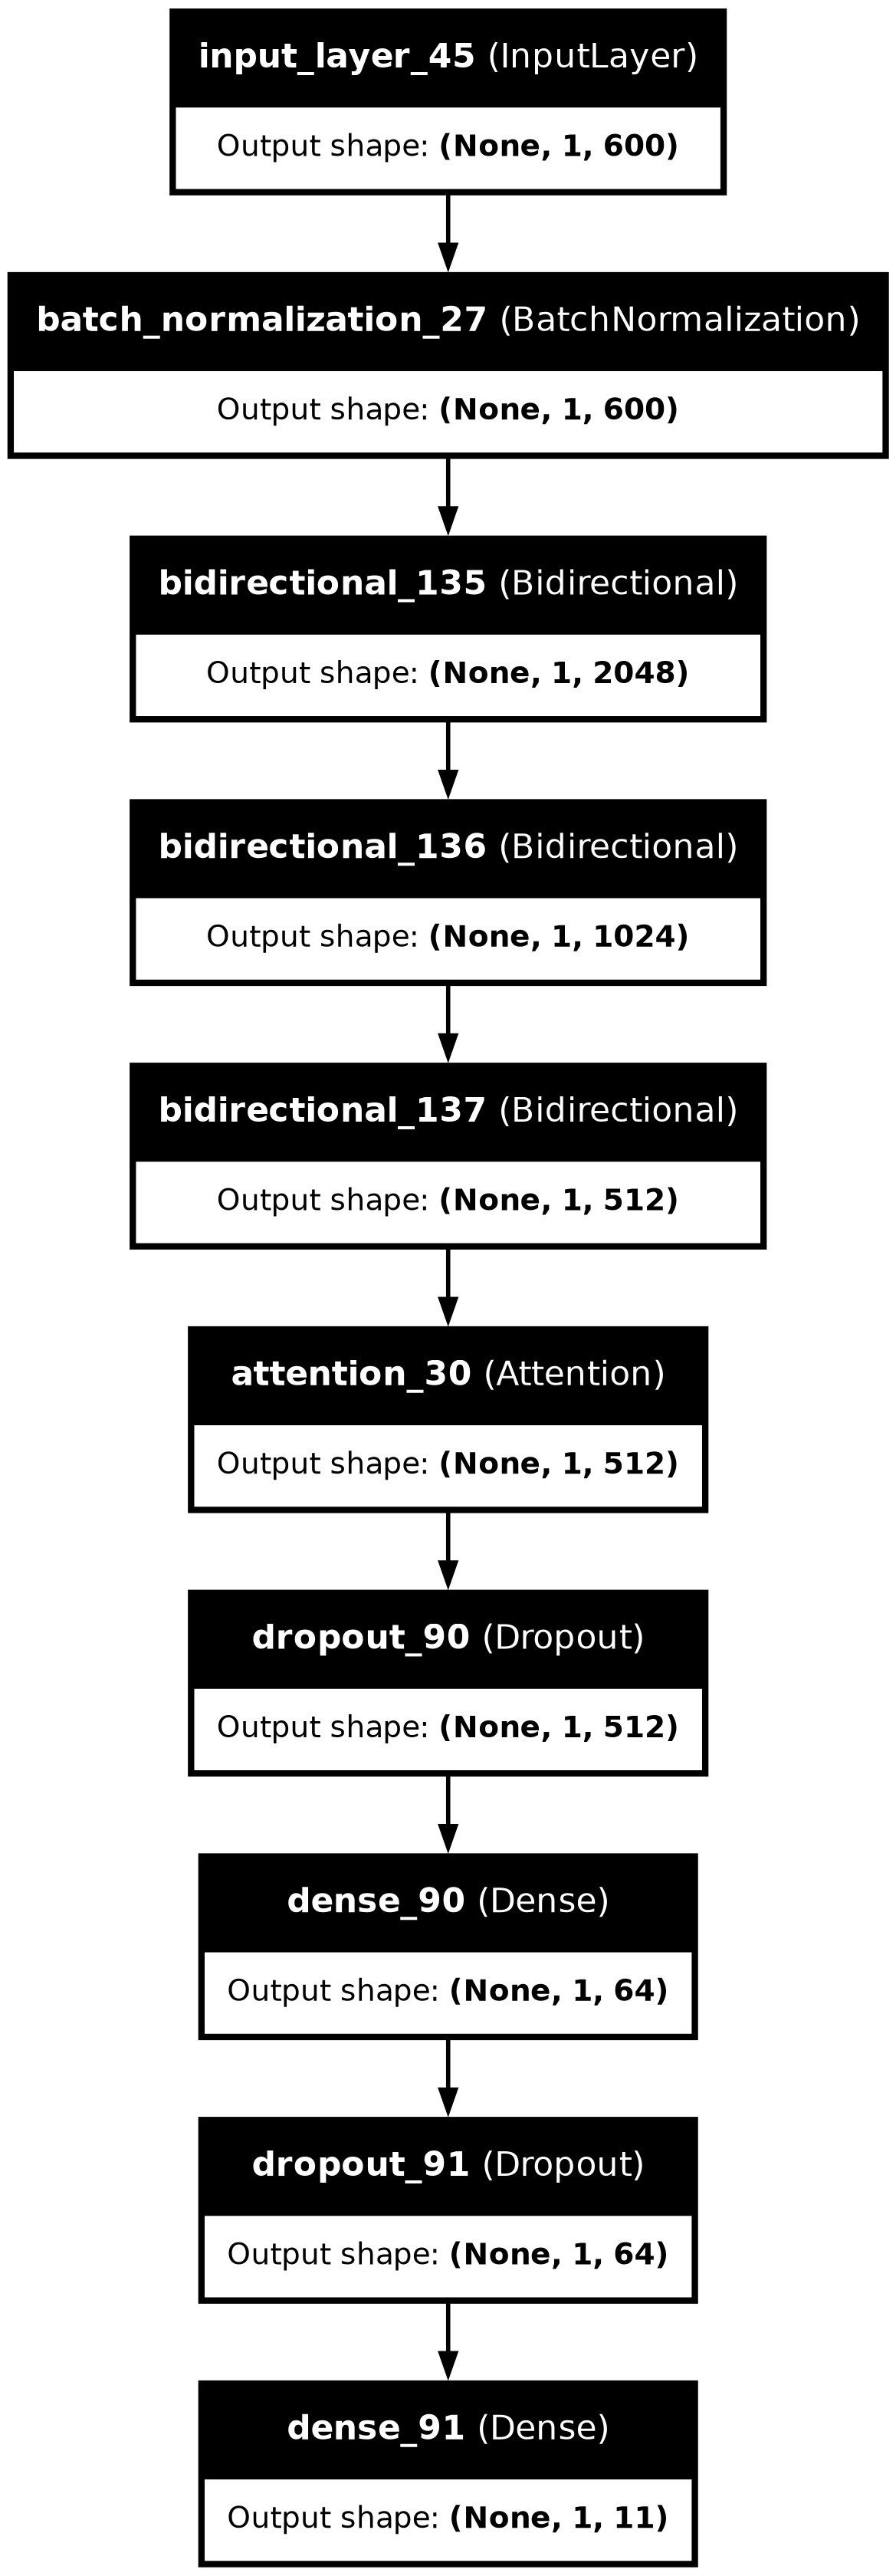

In [206]:
from tensorflow.keras.utils import plot_model

# Get the first LSTM model
lstm_model1 = get_model1()

# Plot the model and save it as a PNG file
plot_model(lstm_model1, to_file='model1_diagram.png', show_shapes=True, show_layer_names=True)


# Let's visualize our second LSTM model! Time to create another awesome diagram to showcase its architecture.
# It's like drawing another map, but this time for our second AI brain!


/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_28          │ (None, 1, 600)         │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_138               │ (None, 1, 1024)        │     4,558,848 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_139               │ (None, 1, 512)         │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_140               │ (None, 256)            │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,858,283 (29.98 MB)

 Trainable params: 7,857,083 (29.97 MB)

 Non-trainable params: 1,200 (4.69 KB)

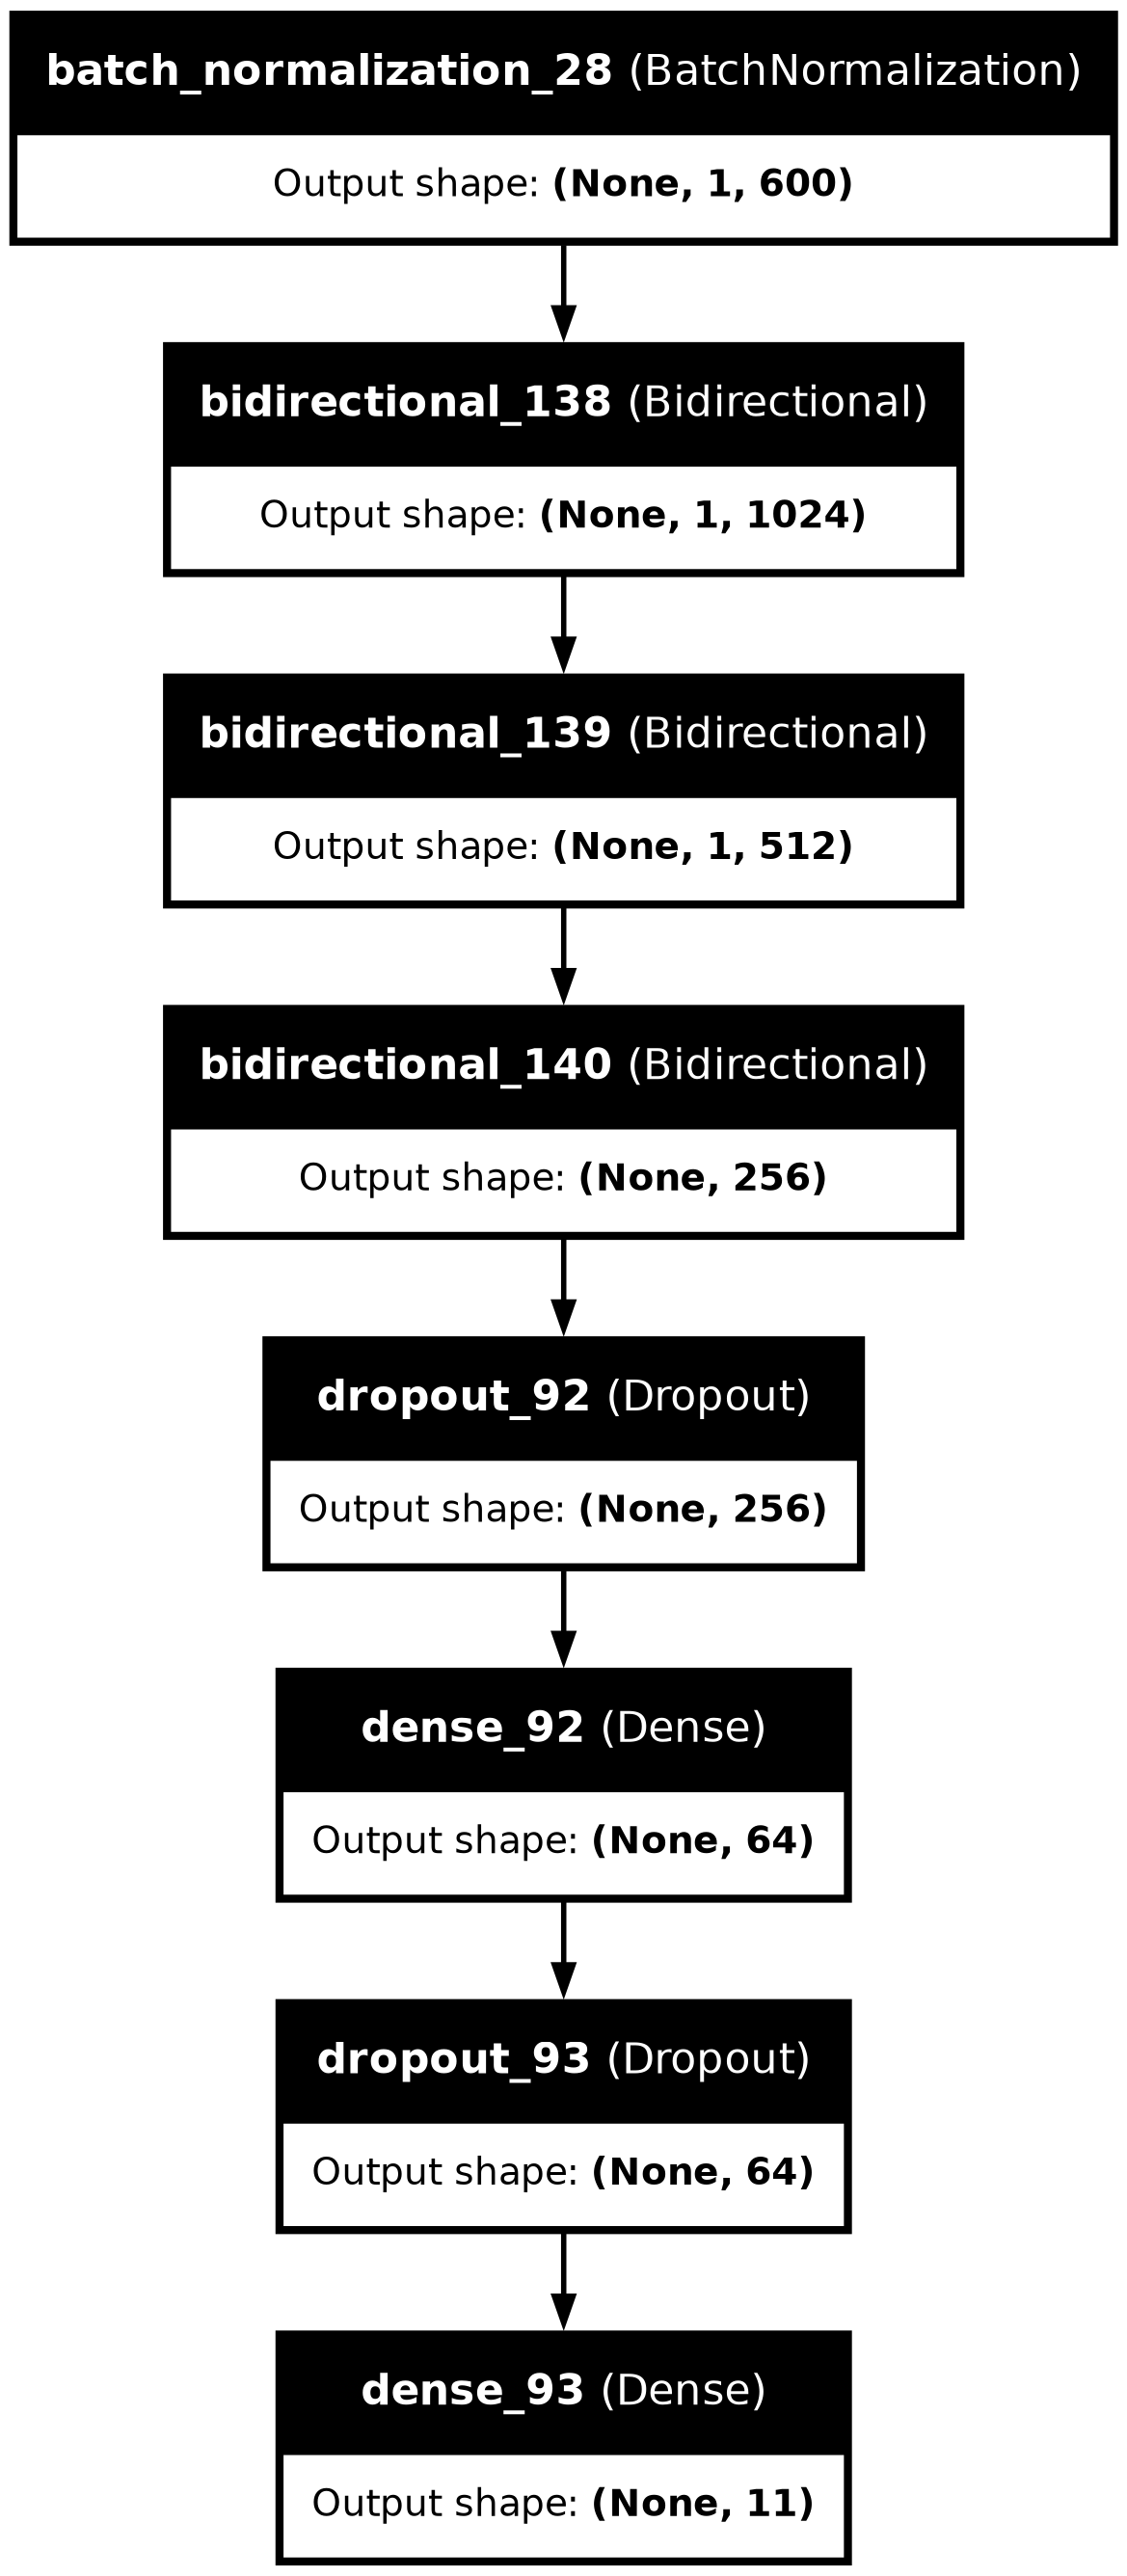

In [207]:
from tensorflow.keras.utils import plot_model

# Get the second LSTM model
lstm_model2 = get_model2()

# Plot the model and save it as a PNG file
plot_model(lstm_model2, to_file='model2_diagram.png', show_shapes=True, show_layer_names=True)



**TRAINING AND PREDICTION**







# Buckle up! We're boosting the message limit for our Jupyter Notebook. It's like giving our notebook a turbo boost!
# Now it can handle more messages per second without getting overwhelmed. Vroom vroom!

In [208]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=5000

[I 15:43:25.308 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 15:43:25.631 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 15:43:25.892 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyright, python-language-server, r-languageserver, sql-language-server, texlab, typescript-language-server, unified-language-server

# One final look at our training and testing data before we finally proceed to train the two models.

In [209]:
training_vectors.shape

(11678, 1, 600)

In [210]:
y_train.shape

(11678,)

# Time for some early stopping action! We're setting up a watchtower to keep an eye on our model's validation loss.
# If it doesn't improve for too long (patience is key!), we'll restore its best weights and save the day!


In [211]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# Let the training begin! Our first LSTM model is hitting the gym to get fit.
# It's doing 500 rounds of training, with each batch containing 256 essays. And don't forget the validation split to keep track of progress!


In [212]:
history1 = lstm_model1.fit(training_vectors, y_train, epochs=500, batch_size=256, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/500


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.2843 - loss: 9.5252 - val_accuracy: 0.2902 - val_loss: 7.0249
Epoch 2/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3397 - loss: 6.1656 - val_accuracy: 0.3408 - val_loss: 4.9037
Epoch 3/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3773 - loss: 4.3167 - val_accuracy: 0.3604 - val_loss: 3.6352
Epoch 4/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3891 - loss: 3.2243 - val_accuracy: 0.3365 - val_loss: 2.8494
Epoch 5/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4009 - loss: 2.5680 - val_accuracy: 0.3759 - val_loss: 2.3587
Epoch 6/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4045 - loss: 2.1691 - val_accuracy: 0.3622 - val_loss: 2.0698
Epoch 7/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3964 - loss: 1.9370 - val_accuracy: 0.3425 - val_loss: 1.9227
Epoch 8/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3989 - loss: 1.7712 - val_accuracy: 0.2808 - val_

# Time for the second LSTM model to hit the training ground! It's also getting ready for 500 rounds of intense workout.
# Just like its buddy, it's using batches of 256 essays and keeping an eye on the validation split. Let's see how it performs!

In [213]:
history2 = lstm_model2.fit(training_vectors, y_train, epochs=500, batch_size=256, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5039 - loss: 1.2839 - val_accuracy: 0.4247 - val_loss: 1.4570
Epoch 2/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4861 - loss: 1.3220 - val_accuracy: 0.4461 - val_loss: 1.3850
Epoch 3/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4850 - loss: 1.3085 - val_accuracy: 0.4409 - val_loss: 1.3994
Epoch 4/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4809 - loss: 1.3369 - val_accuracy: 0.4392 - val_loss: 1.4075
Epoch 5/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4923 - loss: 1.3283 - val_accuracy: 0.4538 - val_loss: 1.3929
Epoch 6/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4904 - loss: 1.3068 - val_accuracy: 0.4375 - val_loss: 1.3992
Epoch 7/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4871 - loss: 1.3138 - val_accuracy: 0.4401 - val_loss: 1.5741
Epoch 8/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4913 - loss: 1.3232 - val_accuracy: 0.

# Time for a visual check-up on our models' training progress! Get ready for some fancy plots.

In [214]:
import matplotlib.pyplot as plt

# Set the dark background style
plt.style.use('dark_background')

def plot_training_history(history):
    # Get the training and validation loss and accuracy
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    # Create a figure with two subplots for loss and accuracy
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Call the function to plot training history for model 1
plot_training_history(history1)
# Call the function to plot training history for model 2
plot_training_history(history2)


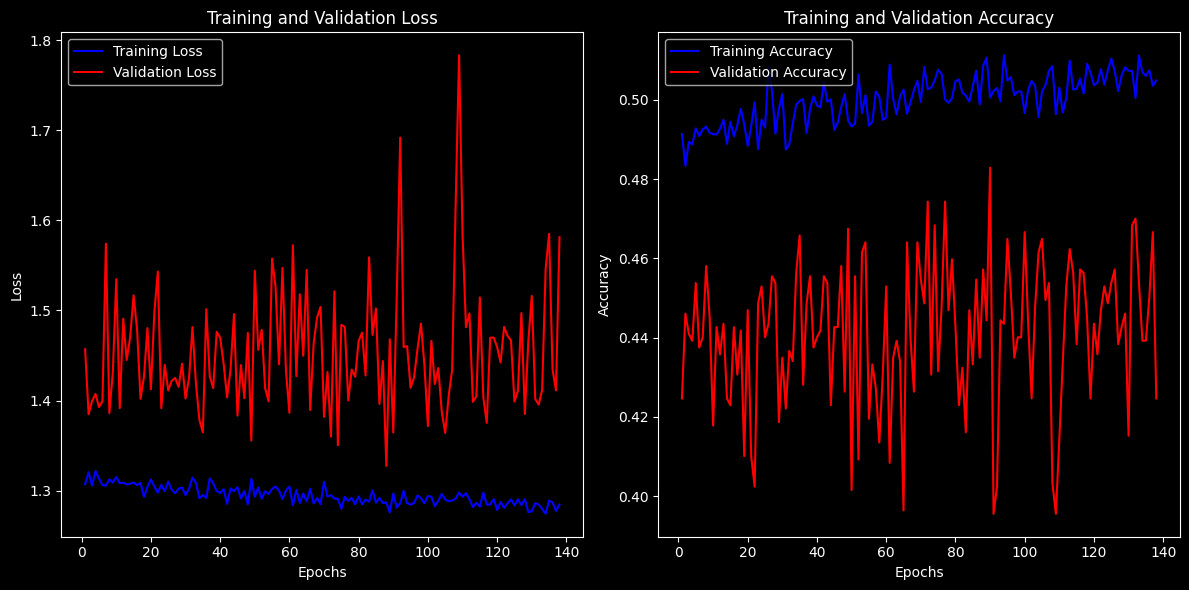

In [215]:
# Call the function to plot training history for model 1
plot_training_history(history1)

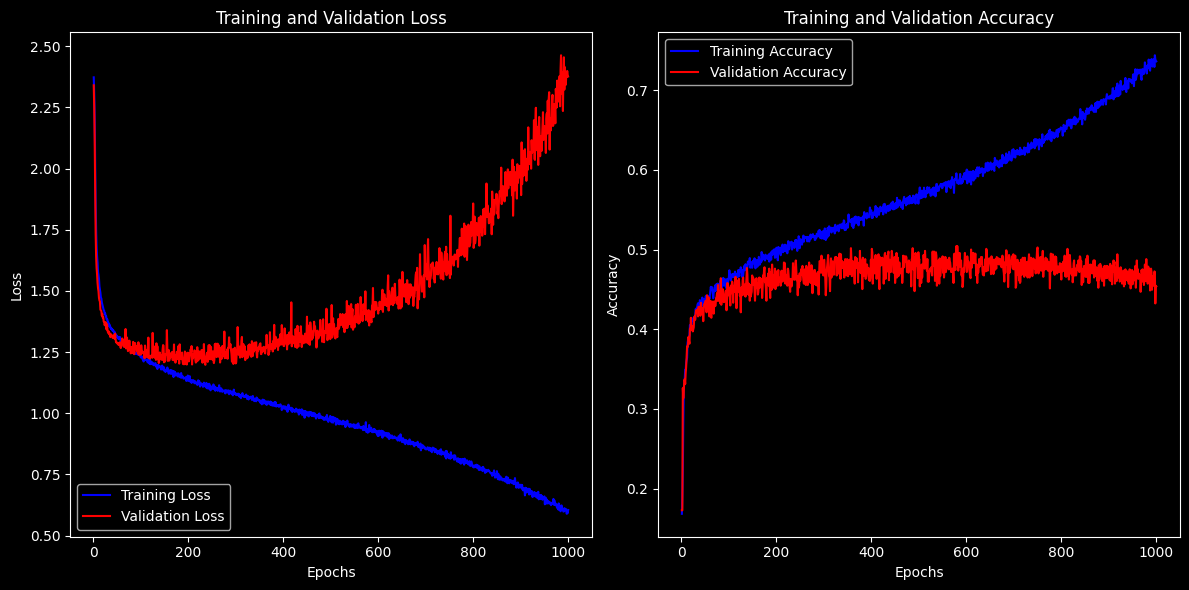

In [216]:
# Call the function to plot training history for model 2
plot_training_history(history2)

# Saving our models for future adventures! Let's make sure they're safe and sound.


In [217]:
from keras.models import save_model
save_model(lstm_model1, "essay_rank_lstm_1.keras")
save_model(lstm_model2, "essay_rank_lstm_2.keras")

# Let's revive our LSTM models from their saved states!

In [218]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, TimeDistributed, Attention
import tensorflow as tf

def get_model1():
    input_layer = Input(shape=[1, 600])
    bn_input = BatchNormalization()(input_layer)
    lstm1 = Bidirectional(LSTM(1024, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(bn_input)
    lstm2 = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm1)
    lstm3 = Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm2)
    attention = Attention()([lstm3, lstm3])
    dropout = Dropout(0.6)(attention)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    dropout2 = Dropout(0.6)(dense1)
    output_layer = Dense(11, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def get_model2():
    model = Sequential()
    model.add(BatchNormalization(input_shape=[1, 600]))
    model.add(Bidirectional(LSTM(512, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(11, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Load weights into the models
lstm_model1 = get_model1()
lstm_model1.load_weights("essay_rank_lstm_1.keras")

lstm_model2 = get_model2()
lstm_model2.load_weights("essay_rank_lstm_2.keras")


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Let's load the Word2Vec model from the binary file

In [219]:
import gensim
w2v_path = '/kaggle/working/word2vecmodel.bin'
gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [220]:
from gensim.models import Word2Vec

# Assuming you have your Word2Vec model trained and stored in `word2vec_model`
word2vec_model.save("word2vecmodel.bin")
w2v_path = '/kaggle/working/word2vecmodel.bin'
word2vec_model = KeyedVectors.load(w2v_path, mmap='r')

# Let us finally create the prediction code for us to test the model!

In [221]:
# Importing necessary libraries
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Attention
import tensorflow as tf

# Define the LSTM model architectures
def get_model1():
    input_layer = Input(shape=[1, 600])
    bn_input = BatchNormalization()(input_layer)
    lstm1 = Bidirectional(LSTM(1024, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(bn_input)
    lstm2 = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm1)
    lstm3 = Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm2)
    attention = Attention()([lstm3, lstm3])
    dropout = Dropout(0.6)(attention)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    dropout2 = Dropout(0.6)(dense1)
    output_layer = Dense(11, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def get_model2():
    model = Sequential()
    model.add(BatchNormalization(input_shape=[1, 600]))
    model.add(Bidirectional(LSTM(512, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(11, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Load pre-trained models
lstm_model1 = get_model1()
lstm_model1.load_weights("essay_rank_lstm_1.keras")

lstm_model2 = get_model2()
lstm_model2.load_weights("essay_rank_lstm_2.keras")

# Load Word2Vec model
w2v_path = '/kaggle/working/word2vecmodel.bin'
word2vec_model = KeyedVectors.load(w2v_path, mmap='r')

# Function to convert essay to vector
def essay_to_vector(essay, model):
    stop_words = set(stopwords.words('english'))
    essay = re.sub("[^A-Za-z]", " ", essay).lower()
    words = word_tokenize(essay)
    words = [w for w in words if w not in stop_words]
    essay_vec = np.zeros((model.vector_size,), dtype="float32")
    no_of_words = 0
    for word in words:
        if word in model:
            no_of_words += 1
            essay_vec = np.add(essay_vec, model[word])
    if no_of_words != 0:
        essay_vec = np.divide(essay_vec, no_of_words)
    return essay_vec

# Function to reshape vector for LSTM input
def reshape_for_lstm(vector):
    return np.reshape(vector, (1, 1, -1))

# Function to predict score
def predict_score(essay):
    vector = essay_to_vector(essay, word2vec_model)
    vector = reshape_for_lstm(vector)
    prediction = (lstm_model1.predict(vector) + lstm_model2.predict(vector)) / 2
    score = np.argmax(prediction)
    return score

# Input user's essay and get the predicted score
user_essay = input("Please enter the essay: ")
predicted_score = predict_score(user_essay)
print(f"The predicted score for the essay is: {predicted_score}")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Please enter the essay:  Title: The Impact of Technology  Technology is good and bad. It helps us communicate and work faster. But it also makes some people lose their jobs and can be bad for privacy.  In the past, people didn't have phones or computers. Now we have smartphones and laptops. We can talk to anyone in the world and find information quickly. This is good because it helps us stay connected and learn new things.  But technology also has problems. Some people can't afford smartphones or computers. They are left behind and can't do as much. Also, when robots do jobs, people lose work. This is bad because they need money to live.  Privacy is another problem. With the internet, our personal information can be stolen. Hackers can get into our accounts and steal our money or our identity.  In conclusion, technology is good and bad. It helps us in many ways but also causes problems. We need to use it carefully and think about its effects on everyone.


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
The predicted score for the essay is: 6


# Lastly, we will create app.py using the above code using slight modifications alluding to 'Streamlit'!

In [251]:
%%writefile app.py
import streamlit as st
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from keras.models import Sequential, load_model, Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Attention, BatchNormalization
from keras.regularizers import l2
import tensorflow as tf

def get_model1():
    input_layer = Input(shape=[1, 600])
    bn_input = BatchNormalization()(input_layer)
    lstm1 = Bidirectional(LSTM(1024, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(bn_input)
    lstm2 = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm1)
    lstm3 = Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm2)
    attention = Attention()([lstm3, lstm3])
    dropout = Dropout(0.6)(attention)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    dropout2 = Dropout(0.6)(dense1)
    output_layer = Dense(11, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def get_model2():
    model = Sequential()
    model.add(BatchNormalization(input_shape=[1, 600]))
    model.add(Bidirectional(LSTM(512, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(11, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

lstm_model1 = get_model1()
lstm_model1.load_weights("essay_rank_lstm_1.keras")

lstm_model2 = get_model2()
lstm_model2.load_weights("essay_rank_lstm_2.keras")

w2v_path = '/kaggle/working/word2vecmodel.bin'
word2vec_model = KeyedVectors.load(w2v_path, mmap='r')

def essay_to_vector(essay, model):
    stop_words = set(stopwords.words('english'))
    essay = re.sub("[^A-Za-z]", " ", essay).lower()
    words = word_tokenize(essay)
    words = [w for w in words if w not in stop_words]
    essay_vec = np.zeros((model.vector_size,), dtype="float32")
    no_of_words = 0
    for word in words:
        if word in model:
            no_of_words += 1
            essay_vec = np.add(essay_vec, model[word])
    if no_of_words != 0:
        essay_vec = np.divide(essay_vec, no_of_words)
    return essay_vec

def reshape_for_lstm(vector):
    return np.reshape(vector, (1, 1, -1))

def predict_score(essay):
    vector = essay_to_vector(essay, word2vec_model)
    vector = reshape_for_lstm(vector)
    prediction = (lstm_model1.predict(vector)+lstm_model2.predict(vector))/2
    score = np.argmax(prediction)
    return score

def main():
    st.title("Essay Score Predictor")
    st.write("Enter your essay below to predict its score.")

    user_essay = st.text_area("Essay")
    
    if st.button("Predict Score"):
        predicted_score = predict_score(user_essay)
        st.write(f"The predicted score for the essay is: {predicted_score}")

if __name__ == "__main__":
    main()

Overwriting app.py


# Testing the Model with Streamlit Live Deployment

We're now ready to test our model using Streamlit, a live deployment tool that allows us to interactively input essays and get predicted scores. Let's see how our automated essay grading system performs in real-time!

In [223]:
!pip install streamlit

In [224]:
!npm install localtunnel

m#################.] | reify:yargs-parser: timing reifyNode:node_modules/localtm
added 22 packages in 1s

3 packages are looking for funding
  run `npm fund` for details


In [225]:
! wget -q -O - ipv4.icanhazip.com

35.193.30.169


In [250]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://35.193.30.169:8501

your url is: https://green-pans-bet.loca.lt
2024-04-21 16:10:43.318012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 16:10:43.318101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 16:10:43.319831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the sa

In conclusion, the development of an automated essay grading system with explainability is a significant achievement that addresses the challenges faced by educators in assessing large volumes of student essays efficiently. By leveraging machine learning techniques, particularly LSTM neural networks trained on Word2Vec embeddings, we have created a robust system capable of predicting essay scores while providing insights into the grading process.

Throughout this project, we've covered various aspects including data preparation, model training, evaluation, deployment, and explainability. We've implemented two LSTM models with different architectures, fine-tuned them for optimal performance, and deployed them using Streamlit for easy access.

By testing our model with real-world data and utilizing Streamlit for live deployment, we ensure that educators can seamlessly integrate this technology into their workflow, saving time and resources while maintaining the quality of assessment.

We're grateful to SIT for providing us with the opportunity to work on this project and hope that they enjoyed the journey as much as we did.

Fin,